In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Bruit d'une machine à laver le linge

In [2]:
# La fréquence typique est d'environ 1400 tour minutes pour l'essorage soit en Hz
1400/60.

23.333333333333332

In [3]:
directory = "/home/lumi/lumi/2017/Lumi2017-master/TD_PSD/data/"
file_name = directory + '2016-03-02-22:11:53.wav'

from scipy.io.wavfile import read

In [4]:
# La fonction read renvoie deux valeurs : le taux d'échantillonage et le tableau de points
samplerate, amplitude = read(file_name)

In [5]:
amplitude = amplitude[44100:]/2**15

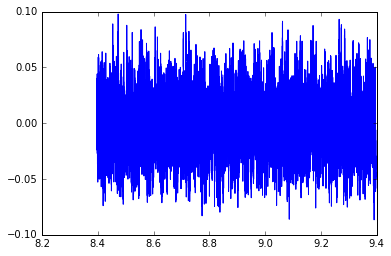

In [6]:
t = arange(len(amplitude))/samplerate # Attention, il est fortement déconseillé d'utilisé linspace
plot(t[-samplerate:], amplitude[-samplerate:])

In [7]:
from scipy.signal import periodogram

(1e-09, 0.0004)

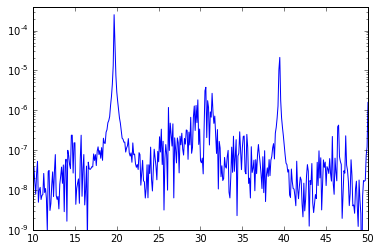

In [8]:
# Il faut fournir le tableau de point et le taux d'échantillonage pour pouvoir calculer la dsp
# la fonction periodogram renvoie la fréquence et le dsp.
freq, psd = periodogram(amplitude, fs=samplerate)
semilogy(freq, psd)
xlim(10, 50)
ylim(1E-9, 4E-4)

In [9]:
# Le bruit typique et de quelques 10^-8 V^2/Hz
# Soit un bruit rms de qq E-3 sur une bande de 100Hz

0.005161288311052465

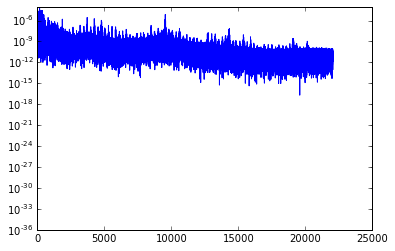

In [10]:
freq, psd = periodogram(amplitude, fs=samplerate, scaling="spectrum")
semilogy(freq, psd)

# Amplitude du signal
sqrt(psd[(freq>10) & (freq<50)].max())

(1e-11, 0.001)

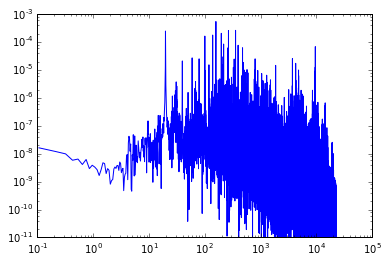

In [11]:
freq, psd = periodogram(amplitude, fs=samplerate)
loglog(freq, psd)
ylim(1E-11, 1E-3)

In [12]:
# On voit que l'essentiel du bruit provient des hautes fréquences. Il va falloir filtrer.

# Filtre par transformée de Fourier

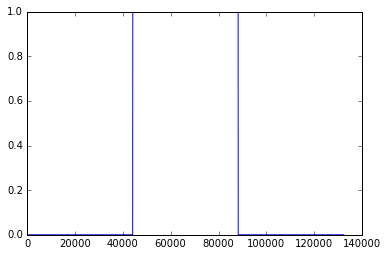

In [13]:
samplerate = 44100
signal = zeros(samplerate*3)
signal[samplerate:(2*samplerate)] = 1
plot(signal)

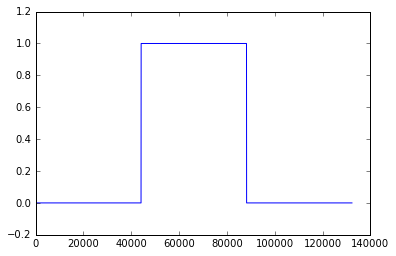

In [14]:
signal_tilde = np.fft.rfft(signal)
signal_2 = np.fft.irfft(signal_tilde)
plot(signal_2)

In [15]:
# On retrouve le bon signal
# Il suffit maintenant de filtrer la variable signal_tilde, ce qui se fait directement

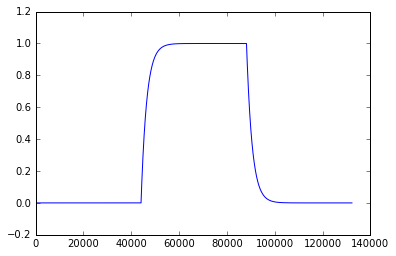

In [16]:
from numpy.fft import rfftfreq
signal_tilde = np.fft.rfft(signal)
freq = rfftfreq(len(signal), d=1/samplerate)
fc = 3
signal_2 = np.fft.irfft(signal_tilde/(1+1j*freq/fc))
plot(signal_2)

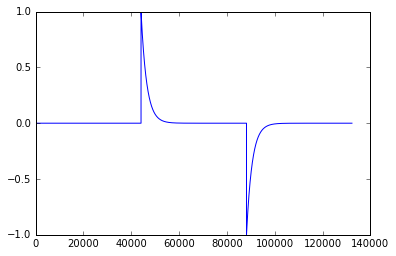

In [17]:
signal_tilde = np.fft.rfft(signal)
freq = rfftfreq(len(signal), d=1/samplerate)
fc = 3
signal_2 = np.fft.irfft(1j*freq/fc*signal_tilde/(1+1j*freq/fc))
plot(signal_2)

In [33]:
def passe_haut(signal, fc, samplerate):
    """ Filtre passe haut d'ordre 1

    input:
        signal : le signal que l'on veut filter
        fc : la fréquence de coupure
        samplerate : le taux d'échantillonage
        
    output : 
        le signal filtré
    """
    signal_tilde = np.fft.rfft(signal)
    freq = rfftfreq(len(signal), d=1/samplerate)
    signal_2 = np.fft.irfft(1j*freq/fc*signal_tilde/(1+1j*freq/fc))    
    return signal_2

def passe_bas(signal, fc, samplerate):
    """ Filtre passe bas d'ordre 1

    input:
        signal : le signal que l'on veut filter
        fc : la fréquence de coupure
        samplerate : le taux d'échantillonage
        
    output : 
        le signal filtré
    """
    signal_tilde = np.fft.rfft(signal)
    freq = rfftfreq(len(signal), d=1/samplerate)
    signal_2 = np.fft.irfft(signal_tilde/(1+1j*freq/fc))    
    return signal_2

plot(passe_haut(signal, 3, samplerate=samplerate))
plot(passe_bas(signal, 3, samplerate=samplerate))


NameError: name 'signal' is not defined

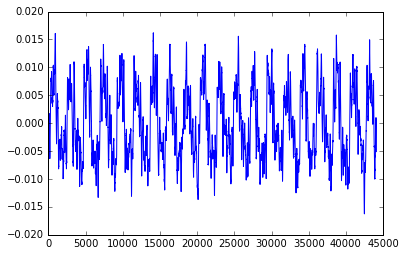

In [19]:
samplerate, amplitude = read(file_name)
amplitude = amplitude[44100:]/2**15
plot(passe_bas(amplitude[-44100:], 30, samplerate=samplerate))

In [1]:
# On retrouve un signal avec une amplitude rms typique de 5 mV, comme nous l'avions calculé précédement. 

# Onde gravitationnelle

In [3]:
from readligo import loaddata

In [11]:
strain, time, _ = loaddata('data/H-H1_LOSC_4_V1-1126259446-32.hdf5')

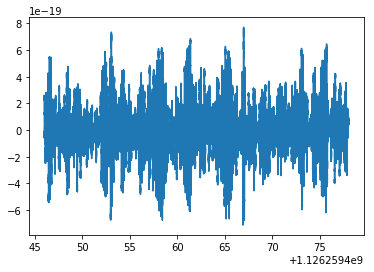

In [12]:
plot(time, strain)

(-5, 5)

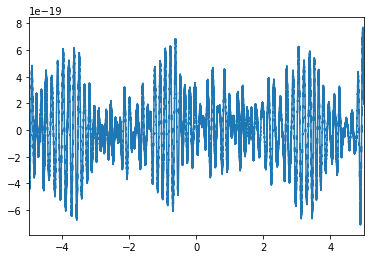

In [14]:
t_event = time.mean()
plot(time - t_event, strain)
xlim(-5, 5)

(1e-46, 1e-37)

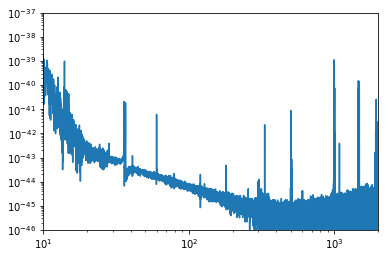

In [22]:
from scipy.signal import periodogram

sample_rate = 1/((time[1] - time[0]))
freq, psd = periodogram(strain, fs=sample_rate)
loglog(freq, psd)
xlim(10, 2E3)
ylim(1E-46, 1E-37)

(1e-47, 1e-37)

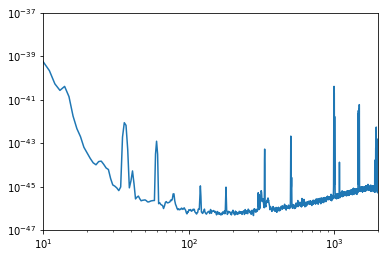

In [25]:
from scipy.signal import welch

sample_rate = 1/((time[1] - time[0]))
freq, psd = welch(strain, fs=sample_rate, nperseg=sample_rate)
loglog(freq, psd)
xlim(10, 2E3)
ylim(1E-47, 1E-37)

In [26]:
strain.std()

2.2089152875422851e-19

In [30]:
from scipy.interpolate import interp1d    

def whiten(strain, dt):
    freqs, psd_welch = welch(strain, fs=1/dt, nperseg=int(1/dt))
    interp_psd = interp1d(freqs, psd_welch)

    N = len(strain)
    freqs = np.fft.rfftfreq(N, dt)

    strain_tilde = np.fft.rfft(strain)
    gain = 1 / np.sqrt(interp_psd(freqs))
    gain = gain/gain.max()
    white_strain_tilde = strain_tilde * gain
    white_strain = np.fft.irfft(white_strain_tilde)
    return white_strain


strain_whiten = whiten(strain, dt=1/sample_rate)

(-5e-21, 5e-21)

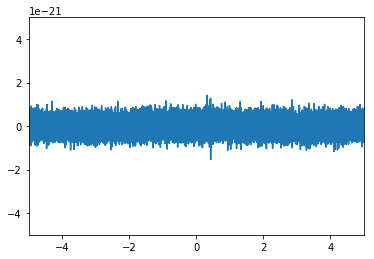

In [32]:
t_event = time.mean()
plot(time - t_event, strain_whiten)
xlim(-5, 5)
ylim(-5E-21, 5E-21)

(-2e-21, 2e-21)

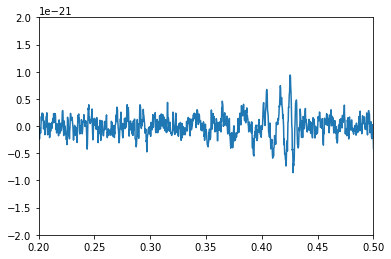

In [37]:
strain_whiten_LP = passe_bas(strain_whiten, 300, sample_rate)
strain_whiten_LP_HP = passe_haut(strain_whiten_LP, 20, sample_rate)
t_event = time.mean()
plot(time - t_event, strain_whiten_LP_HP)
xlim(0.2, 0.5)
ylim(-2E-21, 2E-21)

(-2e-21, 2e-21)

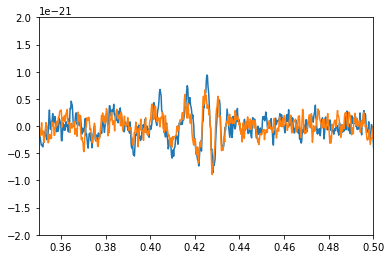

In [44]:
strain_H1, time, _ = loaddata('data/H-H1_LOSC_4_V1-1126259446-32.hdf5')
strain_L1, time, _ = loaddata('data/L-L1_LOSC_4_V1-1126259446-32.hdf5')

strain_H1_whiten = whiten(strain_H1, dt=1/sample_rate)
strain_L1_whiten = whiten(strain_L1, dt=1/sample_rate)

strain_H1_whiten_LP = passe_bas(strain_H1_whiten, 300, sample_rate)
strain_H1_whiten_LP_HP = passe_haut(strain_H1_whiten_LP, 20, sample_rate)

strain_L1_whiten_LP = passe_bas(strain_L1_whiten, 300, sample_rate)
strain_L1_whiten_LP_HP = passe_haut(strain_L1_whiten_LP, 20, sample_rate)


t_event = time.mean()
plot(time - t_event, strain_H1_whiten_LP_HP)
plot(time - t_event+7E-3, -strain_L1_whiten_LP_HP)
xlim(0.35, 0.5)
ylim(-2E-21, 2E-21)




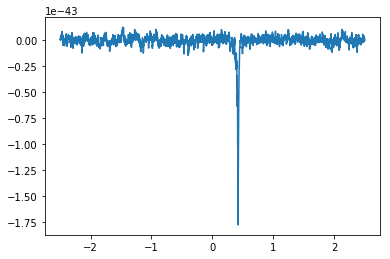

In [55]:
start = int(len(time)/2 - 2.5*sample_rate)
stop = int(len(time)/2 + 2.5*sample_rate)
delai = int(7E-3*sample_rate)
correlation = (strain_L1_whiten_LP_HP[start:stop] *
        strain_H1_whiten_LP_HP[start+delai:stop+delai])
correlation_filt = passe_bas(correlation, 20, samplerate=sample_rate)

plot(time[start:stop]-t_event, correlation_filt)
